
# Analysis Tutorial

Welcome to the DNA analysis tutorial using the MDNA module. This notebook will demonstrate different techniques to analyze DNA structures, including simulations, parameter extractions, and visualization of dynamics. You'll learn to:
- Simulate DNA structures using OpenMM.
- Extract and analyze different structural parameters.
- Visualize these parameters to understand DNA behavior.


In [1]:
import numpy as np
import mdtraj as md
import matplotlib.pyplot as plt
import seaborn as sns

import mdna 

### DNA Simulation with OpenMM

Molecular Dynamics (MD) simulations are computational methods used to study the physical movements of atoms and molecules over time. By simulating the interactions and dynamics of molecular structures, MD provides insights into the structural, dynamic, and thermodynamic properties of biological molecules like DNA.

#### About OpenMM
OpenMM is a toolkit for molecular simulations, designed to be extremely flexible and highly efficient. It allows for the rapid development of algorithms and the construction of custom molecular dynamics applications. It is especially optimized for high-performance simulations, making it ideal for studies that require complex, large-scale computations.

#### Simulation Process
1. **Initialization**: We start by creating a DNA simulation from a given sequence. This involves setting up the initial conditions, such as the DNA sequence itself, simulation time, and whether the system should be solvated (surrounded by a solvent, typically water).
   
2. **Centering Coordinates**: To ensure that the DNA structure is properly oriented and centered in the simulation box, we adjust the coordinates. This is crucial for avoiding any boundary issues during the simulation.

3. **Imaging Molecules**: This step involves adjusting the positions of molecules relative to each other based on an anchor molecule. Typically, this helps in maintaining the integrity of the structure throughout the simulation, preventing it from drifting apart across periodic boundaries.

4. **Superposition**: Finally, the trajectory is superposed to a reference frame (usually the first frame) to eliminate any rotational and translational movements that are not intrinsic to the molecule's dynamics.

#### Note
This simulation might take a while to run, depending on the complexity of the DNA sequence and the computational resources available. It's performed to understand the dynamic behavior of the DNA molecule in a simulated physiological environment. Alternatively, you might load your own MD trajectory containing a DNA structure for the purpose of this tutorial.


In [2]:
# Initiate a DNA simulation using OpenMM 
traj = mdna.sequence_to_md(sequence='GCAATATATTGC', time=1, time_unit='picoseconds', solvated=True, save_location='./data/')
traj.center_coordinates()


Start rescaling spline based on requested number of base pairs.
	This requires recomputation of the control points to match the desired number of base pairs.
	Spline scaled to match the target number of base pairs: 12



Initialize DNA openMM simulation at 310 K for 1 ps time units
Solvate DNA with padding of 1.0 nm and 0.1 M KCl
Minimize energy
Run simulation for 500 steps
Simulation completed
Saved trajectory as: ./data/my_dna.h5


<mdtraj.Trajectory with 5 frames, 17169 atoms, 5521 residues, and unitcells at 0x17c8a88c0>

### Managing DNA Coordinates
Find a residue in the middle, anchor molecules, and adjust the DNA in the simulation box.

In [3]:
# Find index of residue in the middle of the DNA structure
indices = traj.top.select('resid 4')
residx = traj.topology.atom(indices[0]).residue.index
anchor_molecules=[set(traj.topology.residue(residx).atoms)]

# Put everything in the same box based on the anchor residue
traj = traj.image_molecules(anchor_molecules=anchor_molecules)
traj = traj.superpose(traj, 0)

## Loading and Analyzing DNA Structure
Load the trajectory, extract mean reference frames, and view base reference frames.

In [4]:
# Load the trajectory
dna = mdna.load(traj)

# Extract mean reference frames and base reference frames
mean_frames = dna.get_frames()
print(mean_frames.shape)

base_frames = dna.get_base_frames()
for res, ref in base_frames.items():
    print(res, ref.shape)
    break

(12, 5, 4, 3)
DG1 (5, 4, 3)


## Extracting and Visualizing Rigid Base Parameters
Show how to extract and parameters

In [5]:
# Extract and visualize parameters
base, names = dna.get_parameters(base=True)
print(base.shape, names)

step, names = dna.get_parameters(step=True)
print(step.shape, names)

params, names = dna.get_parameters()
print(params.shape, names)

(5, 12, 6) ['shear', 'stretch', 'stagger', 'buckle', 'propeller', 'opening']
(5, 12, 6) ['shift', 'slide', 'rise', 'tilt', 'roll', 'twist']
(5, 12, 12) ['shear', 'stretch', 'stagger', 'buckle', 'propeller', 'opening', 'shift', 'slide', 'rise', 'tilt', 'roll', 'twist']


We can also extract just a single parameter

In [6]:
name = 'twist'
para = dna.get_parameter(name)
print(para.shape)

(5, 12)


Next we plot

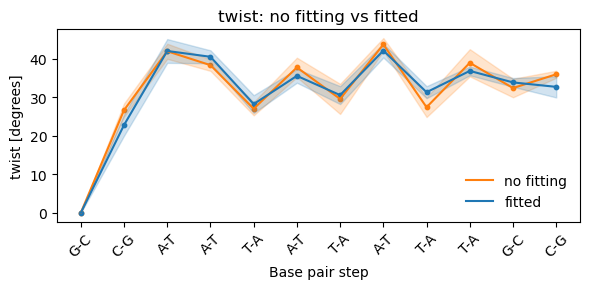

In [7]:
# Plot the twist parameter with overlay of fitted-reference analysis
fig, ax = plt.subplots(figsize=[6,3])

# Original (no fitting)
name = 'twist'
para = dna.get_parameter(name)
mean = np.mean(para, axis=0)
std = np.std(para, axis=0)
x = np.arange(len(mean))
ax.fill_between(x, mean-std, mean+std, color='tab:orange', alpha=0.20)
ax.plot(x, mean, color='tab:orange', lw=1.5, label='no fitting')
ax.scatter(x=x, y=mean, color='tab:orange', s=10)

# Fitted (canonical-base alignment)
rigid_fit = mdna.compute_rigid_parameters(traj, chainids=[0, 1], fit_reference=True)
para_fit = rigid_fit.get_parameter(name)
mean_fit = np.mean(para_fit, axis=0)
std_fit = np.std(para_fit, axis=0)
ax.fill_between(x, mean_fit-std_fit, mean_fit+std_fit, color='tab:blue', alpha=0.20)
ax.plot(x, mean_fit, color='tab:blue', lw=1.5, label='fitted')
ax.scatter(x=x, y=mean_fit, color='tab:blue', s=10)

ax.set_title(f'{name}: no fitting vs fitted')
ax.set_ylabel(f'{name} [degrees]')
ax.set_xlabel('Base pair step')
base_map = dna.base_pair_map
anti_sequence = [base_map[c] for c in dna.sequence]
base_pairs = [f'{i}-{j}' for i, j in zip(dna.sequence, anti_sequence)]
ax.set_xticks(x)
_ = ax.set_xticklabels(base_pairs, rotation=45)
ax.legend(frameon=False)
fig.tight_layout()

### Why fit bases before defining reference frames?

Low-resolution structures and MD snapshots can contain small base deformations. If we compute base frames directly from deformed atoms, those deformations can leak into rigid-base parameters as extra noise.

Following the Curves+ idea, we can first perform a least-squares fit of a standard (canonical) base geometry to the observed base atoms, then define the base frame from the fitted canonical geometry.

**How the fitting works here (step by step):**
1. Choose a canonical base template (A, C, G, T; U is mapped to T in this implementation).
2. Select common heavy atoms between template and observed residue (hydrogens excluded).
3. Build two paired point clouds: template coordinates and observed coordinates.
4. Remove translation by centering both point clouds at their centroids.
5. Compute the optimal rotation with the Kabsch least-squares solution (via `scipy.spatial.transform.Rotation.align_vectors`).
6. Apply that rotation to the canonical base frame vectors.
7. Place the fitted origin by rotating the canonical origin offset and translating to the observed centroid.
8. Use the transformed canonical frame as the residue frame for parameter analysis.

This is analogous to Curves+ least-squares fitting to standard bases (with fitting optionally enabled/disabled). Here, fitting is controlled by the `fit_reference` flag in rigid-parameter analysis.

/var/folders/n2/v5z2p1nn4f3bx7dhf2zlzdjw0000gn/T/ipykernel_51011/68300235.py:53: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(para_no_fit[:, i], ax=ax_i, color='tab:orange', fill=True, alpha=0.25, lw=1.2, label='no fitting' if i == 0 else None)
/var/folders/n2/v5z2p1nn4f3bx7dhf2zlzdjw0000gn/T/ipykernel_51011/68300235.py:54: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(para_fit[:, i], ax=ax_i, color='tab:blue', fill=True, alpha=0.25, lw=1.2, label='fitted' if i == 0 else None)


no fitting: 0.2959 ± 0.0273 s
fitted:    0.3691 ± 0.0325 s
slowdown (fitted/no fitting): 1.25x


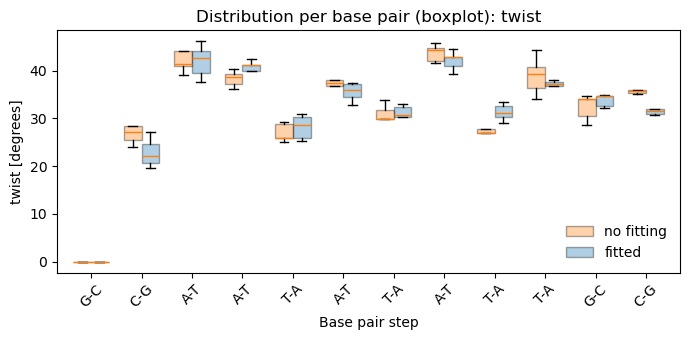

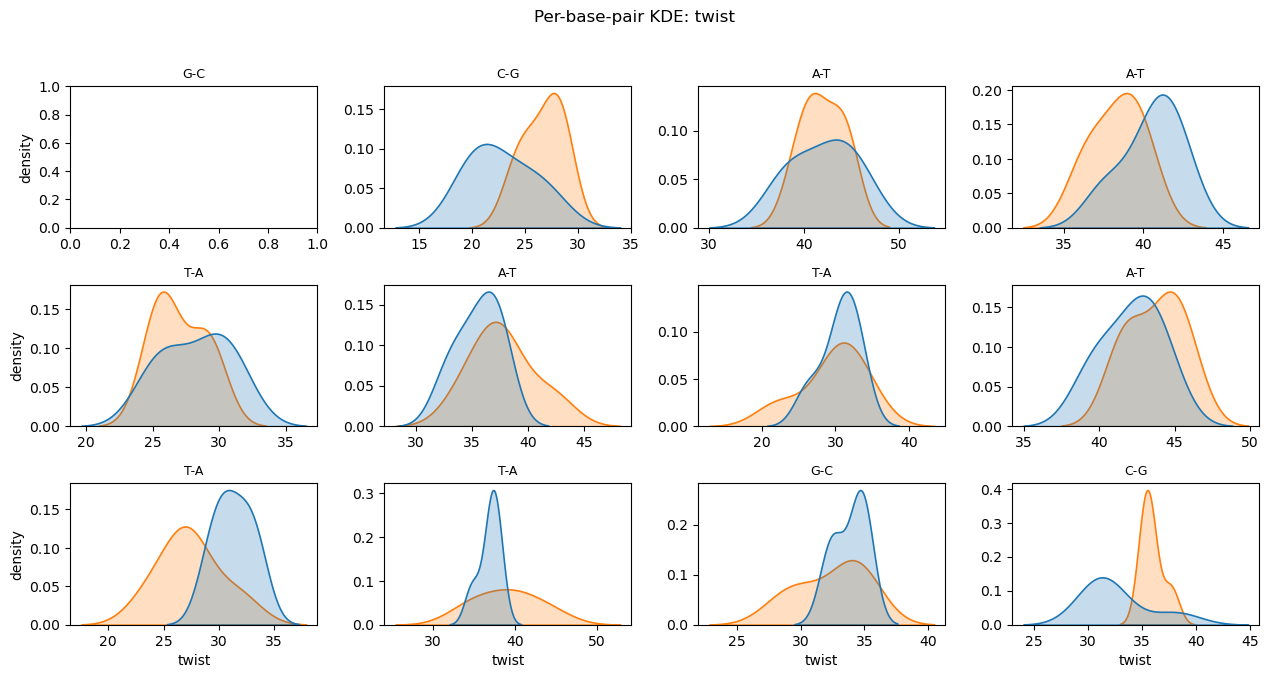

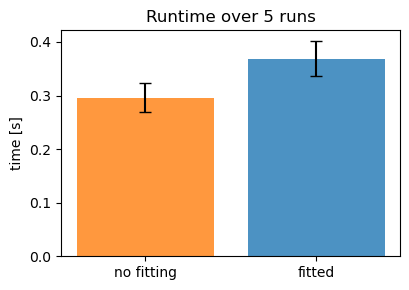

In [8]:
# Per-base-pair distribution comparison (box + KDE) + inference time analysis
import time

target_name = 'twist'

# Collect parameter trajectories for the selected parameter
para_no_fit = dna.get_parameter(target_name)
rigid_fit = mdna.compute_rigid_parameters(traj, chainids=[0, 1], fit_reference=True)
para_fit = rigid_fit.get_parameter(target_name)

n_bp = para_no_fit.shape[1]
x = np.arange(n_bp)
base_map = dna.base_pair_map
anti_sequence = [base_map[c] for c in dna.sequence]
base_pairs = [f'{i}-{j}' for i, j in zip(dna.sequence, anti_sequence)]

# --- Distribution per base pair (across trajectory frames): boxplots ---
fig, ax = plt.subplots(figsize=(max(7, 0.45*n_bp), 3.5))
width = 0.35

bp_no = ax.boxplot(
    [para_no_fit[:, i] for i in range(n_bp)],
    positions=x - width/2, widths=width, patch_artist=True, showfliers=False
 )
bp_fit = ax.boxplot(
    [para_fit[:, i] for i in range(n_bp)],
    positions=x + width/2, widths=width, patch_artist=True, showfliers=False
 )

for patch in bp_no['boxes']:
    patch.set_facecolor('tab:orange')
    patch.set_alpha(0.35)
for patch in bp_fit['boxes']:
    patch.set_facecolor('tab:blue')
    patch.set_alpha(0.35)

ax.set_title(f'Distribution per base pair (boxplot): {target_name}')
ax.set_ylabel(f'{target_name} [degrees]')
ax.set_xlabel('Base pair step')
ax.set_xticks(x)
ax.set_xticklabels(base_pairs, rotation=45)
ax.legend([bp_no['boxes'][0], bp_fit['boxes'][0]], ['no fitting', 'fitted'], frameon=False)
fig.tight_layout()

# --- Distribution per base pair (across trajectory frames): KDE overlays ---
n_cols = min(4, n_bp)
n_rows = int(np.ceil(n_bp / n_cols))
fig_kde, axes = plt.subplots(n_rows, n_cols, figsize=(3.2*n_cols, 2.2*n_rows), sharex=False, sharey=False)
axes = np.atleast_1d(axes).ravel()

for i in range(n_bp):
    ax_i = axes[i]
    sns.kdeplot(para_no_fit[:, i], ax=ax_i, color='tab:orange', fill=True, alpha=0.25, lw=1.2, label='no fitting' if i == 0 else None)
    sns.kdeplot(para_fit[:, i], ax=ax_i, color='tab:blue', fill=True, alpha=0.25, lw=1.2, label='fitted' if i == 0 else None)
    ax_i.set_title(base_pairs[i], fontsize=9)
    ax_i.set_xlabel(target_name if i // n_cols == n_rows - 1 else '')
    ax_i.set_ylabel('density' if i % n_cols == 0 else '')

for j in range(n_bp, len(axes)):
    axes[j].axis('off')

handles, labels = axes[0].get_legend_handles_labels()
if handles:
    fig_kde.legend(handles, labels, loc='upper right', frameon=False)
fig_kde.suptitle(f'Per-base-pair KDE: {target_name}', y=1.02)
fig_kde.tight_layout()

# --- Inference time analysis ---
n_repeats = 5
time_no_fit = []
time_fit = []

for _ in range(n_repeats):
    t0 = time.perf_counter()
    _ = mdna.compute_rigid_parameters(traj, chainids=[0, 1], fit_reference=False)
    time_no_fit.append(time.perf_counter() - t0)

    t0 = time.perf_counter()
    _ = mdna.compute_rigid_parameters(traj, chainids=[0, 1], fit_reference=True)
    time_fit.append(time.perf_counter() - t0)

mean_no, std_no = np.mean(time_no_fit), np.std(time_no_fit)
mean_fit, std_fit = np.mean(time_fit), np.std(time_fit)
slowdown = mean_fit / mean_no if mean_no > 0 else np.nan

fig_t, ax_t = plt.subplots(figsize=(4.2, 3))
ax_t.bar(['no fitting', 'fitted'], [mean_no, mean_fit], yerr=[std_no, std_fit],
         color=['tab:orange', 'tab:blue'], alpha=0.8, capsize=4)
ax_t.set_ylabel('time [s]')
ax_t.set_title(f'Runtime over {n_repeats} runs')
fig_t.tight_layout()

print(f'no fitting: {mean_no:.4f} ± {std_no:.4f} s')
print(f'fitted:    {mean_fit:.4f} ± {std_fit:.4f} s')
print(f'slowdown (fitted/no fitting): {slowdown:.2f}x')

## Advanced Visualization of DNA Parameters
Use statistical visualization to understand distributions of DNA parameters.

Text(0.75, 0.85, 'Step Parameters')

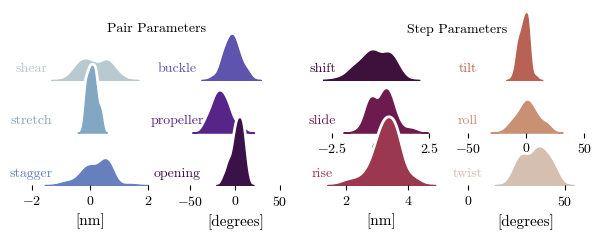

In [9]:
# Example on how to plot KDE's of all parameters
import matplotlib as mpl, matplotlib.font_manager as font_manager
import seaborn as sns
mpl.rcParams['font.family'] = 'serif'
cmfont = font_manager.FontProperties(fname=mpl.get_data_path() + '/fonts/ttf/cmr10.ttf')
mpl.rcParams['font.serif'] = cmfont.get_name()
mpl.rcParams['mathtext.fontset'] = 'cm'
mpl.rcParams['axes.unicode_minus'] = False
mpl.rcParams['axes.formatter.use_mathtext'] = True

colors = sns.color_palette('twilight', 12)
lims = [(-2,2), (-2,2), (-2,2), (-65,65), (-65,65), (-65,65)] + [(-3,3), (-3,3), (1.25,5), (-50,50), (-50,50), (0,60)]
fig, ax = plt.subplots(3, 4, figsize=(6, 2.5), sharey='col')
# ax = ax.flatten()
idx, jdx = 0, 0
for _, name in enumerate(names):
    para = params[:, 1:, names.index(name)]
    sns.kdeplot(para.flatten(), ax=ax[idx][jdx], fill=True, color='white', lw=5)  # density=True
    sns.kdeplot(para.flatten(), ax=ax[idx][jdx], fill=True, color=colors[_], alpha=1, lw=1)  # density=True
    ax[idx][jdx].set_title(name, x=0, y=0, color=colors[_], fontsize=10)
    ax[idx][jdx].set_xlim(lims[_])

    ax[idx][jdx].set_facecolor('none')
    ax[idx][jdx].set_yticklabels([])
    ax[idx][jdx].set_yticks([])
    ax[idx][jdx].set_ylabel('')
    if name in ['shear', 'buckle', 'shift', 'tilt', 'stretch', 'propeller']:
        ax[idx][jdx].set_xticks([])
    idx += 1
    if idx == 3:
        idx = 0
        jdx += 1
    if jdx == 4:
        jdx = 0

    if idx == 0 and jdx in [0, 1, 2, 3]:
        ax[idx][jdx].set_xticklabels([])
    if idx == 1 and jdx in [0, 1]:
        ax[idx][jdx].set_xticklabels([])

ax[-1][0].set_xlabel('[nm]', fontsize=11)
ax[-1][1].set_xlabel('[degrees]', fontsize=11)
ax[-1][2].set_xlabel('[nm]', fontsize=11)
ax[-1][3].set_xlabel('[degrees]', fontsize=11)
fig.tight_layout()
fig.subplots_adjust(hspace=-.25)

sns.despine(bottom=True, left=True)
fig.text(0.25, 0.85, 'Pair Parameters', ha='center', fontsize=10)
fig.text(0.75, 0.85, 'Step Parameters', ha='center', fontsize=10)